# 🤖 Kaggle X Google | 5-Day AI Agents Intensive Course 
# DAY 2b: Agent tools and best practices
🧠 **Exercise : Build an agent that generates images using the MCP server, but requires approval for "bulk" image generation:**

Single image request (1 image): Auto-approve, generate immediately

Bulk request (>1 image): Pause and ask for approval before generating multiple images

I have simulated an AI agent that generates images (using a mock MCP server) with auto-approval for single-image requests and user approval for bulk requests, focusing on workflow and cost management without accessing a real MCP server.


**Setting up Gemini API key and importing required libraries for image processing and async tasks**


In [12]:
import os
import asyncio
import base64
from IPython.display import display, Image as IPImage
import io
from PIL import Image, ImageDraw
import random
import json

try:
    from kaggle_secrets import UserSecretsClient
    GEMINI_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
except:
    GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")

if not GEMINI_API_KEY:
    print(" No API key found, using simulation only")
    GEMINI_API_KEY = "simulation"

os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

print("✅ Gemini Api setup complete")

✅ Gemini Api setup complete


**Simulating MCP server with tools to generate images from text prompts and check usage quota**


In [13]:
class MockMCPServer:
    """MCP server simulation that works in Kaggle"""
    
    def __init__(self):
        self.tools = {
            "generate_image": {
                "name": "generate_image",
                "description": "Generate images from text prompts",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "prompt": {"type": "string", "description": "Image description"},
                        "count": {"type": "integer", "default": 1, "minimum": 1, "maximum": 5}
                    },
                    "required": ["prompt"]
                }
            },
            "get_quota": {
                "name": "get_quota", 
                "description": "Get usage quota information",
                "parameters": {"type": "object", "properties": {}}
            }
        }
    
    async def list_tools(self):
        return list(self.tools.values())
    
    async def call_tool(self, name, arguments):
        if name == "generate_image":
            return await self._generate_image(arguments)
        elif name == "get_quota":
            return {"used": 15, "remaining": 85, "limit": 100}
        else:
            raise ValueError(f"Unknown tool: {name}")
    
    async def _generate_image(self, args):
        prompt = args.get("prompt", "unknown")
        count = args.get("count", 1)
        
        images = []
        for i in range(count):
            # Create simulated image
            img = Image.new('RGB', (400, 300), color=(
                random.randint(50, 200),
                random.randint(50, 200), 
                random.randint(50, 200)
            ))
            draw = ImageDraw.Draw(img)
            draw.text((50, 50), f"MCP Generated", fill=(255,255,255))
            draw.text((50, 80), f"Prompt: {prompt[:20]}", fill=(255,255,255))
            draw.text((50, 110), f"Image {i+1}/{count}", fill=(255,255,255))
            
            # Convert to base64
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            
            images.append({
                "type": "image",
                "data": img_base64,
                "mime_type": "image/png"
            })
        
        return images

print("✅ MCP Server simulation ready")


✅ MCP Server simulation ready


**Creating an Agent that processes user prompts, handles approvals for bulk image requests, and generates images via MCP server with fallback support**


In [21]:
class ImageGenerationAgent:
    def __init__(self, mcp_server):
        self.mcp_server = mcp_server
        self.total_images = 0
        self.bulk_approvals = 0
    
    async def process_request(self, user_prompt: str):
        """Main agent logic with approval workflow"""
        print(f"\n AGENT: Processing '{user_prompt}'")
        
        # Parse count from prompt
        count = 1
        if "2" in user_prompt or "two" in user_prompt.lower():
            count = 2
        elif "3" in user_prompt or "three" in user_prompt.lower():
            count = 3
        elif "4" in user_prompt or "four" in user_prompt.lower():
            count = 4
        elif "5" in user_prompt or "five" in user_prompt.lower():
            count = 5
        
        # Clean prompt
        clean_prompt = user_prompt.replace(str(count), "").replace("images", "").replace("pictures", "").strip()
        
        print(f" Detected: {count} image(s)")
        print(f" Clean prompt: '{clean_prompt}'")
        
        # Approval logic
        if count > 1:
            print(f" BULK REQUEST: {count} images need approval")
            print(f" Estimated cost: ${count * 0.02:.2f}")
            approve = input("✅ Approve? (yes/no): ").strip().lower()
            
            if approve not in ['yes', 'y']:
                print(" Request denied by user")
                return
            
            self.bulk_approvals += 1
            print("✅ Bulk request approved!")
        
        # Use MCP server to generate images
        print(" Using MCP server to generate images...")
        try:
            result = await self.mcp_server.call_tool("generate_image", {
                "prompt": clean_prompt,
                "count": count
            })
            
            # Display images
            print(f" Generated {len(result)} image(s)")
            for img_data in result:
                display(IPImage(data=base64.b64decode(img_data["data"]), width=350))
            
            self.total_images += count
            print(f"Stats: {self.total_images} total images, {self.bulk_approvals} bulk approvals")
            
        except Exception as e:
            print(f"MCP Error: {e}")
            print(" Fallback: Generating locally...")
            await self._fallback_generate(clean_prompt, count)
    
    async def _fallback_generate(self, prompt, count):
        """Fallback image generation"""
        for i in range(count):
            img = Image.new('RGB', (300, 200), color=(
                random.randint(100, 255),
                random.randint(100, 255), 
                random.randint(100, 255)
            ))
            draw = ImageDraw.Draw(img)
            draw.text((30, 30), "FALLBACK IMAGE", fill=(0,0,0))
            draw.text((30, 60), prompt[:15], fill=(0,0,0))
            
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            display(IPImage(data=buffered.getvalue(), width=300))
        
        self.total_images += count

print("✅ Agent system ready")

✅ Agent system ready


**Integrating Gemini ADK to analyze prompts, extract details, handle approvals, and generate styled images via MCP with fallback support**


In [22]:
try:
    # import ADK components
    from google import genai
    from google.genai import types
    
    class GeminiEnhancedAgent:
        def __init__(self, mcp_server):
            self.mcp_server = mcp_server
            self.client = genai.Client(api_key=GEMINI_API_KEY)
            print("✅ Gemini ADK client initialized")
        
        async def smart_process(self, user_prompt: str):
            """Use Gemini to enhance the processing"""
            print(f"\nGEMINI AGENT: Analyzing '{user_prompt}'")
            
            # Use Gemini to understand the request
            try:
                response = self.client.models.generate_content(
                    model="gemini-2.0-flash-exp",
                    contents=f"""
                    Analyze this image generation request: "{user_prompt}"
                    
                    Extract:
                    - Number of images wanted (default to 1)
                    - Main subject/description
                    - Style hints
                    
                    Respond as JSON: {{"count": number, "description": "text", "style": "text"}}
                    """
                )
                
                # Parse Gemini response
                result_text = response.text.strip()
                if "{" in result_text and "}" in result_text:
                    json_str = result_text[result_text.find("{"):result_text.rfind("}")+1]
                    data = json.loads(json_str)
                    count = min(data.get("count", 1), 5)
                    description = data.get("description", user_prompt)
                    style = data.get("style", "general")
                    
                    print(f" Gemini analysis:")
                    print(f"   • Count: {count}")
                    print(f"   • Description: {description}") 
                    print(f"   • Style: {style}")
                    
                    # Approval workflow
                    if count > 1:
                        print(f" Need approval for {count} images")
                        approve = input("Approve? (yes/no): ").lower()
                        if approve not in ['yes', 'y']:
                            return
                    
                    # Generate via MCP
                    result = await self.mcp_server.call_tool("generate_image", {
                        "prompt": f"{description} in {style} style",
                        "count": count
                    })
                    
                    for img_data in result:
                        display(IPImage(data=base64.b64decode(img_data["data"]), width=350))
                    
                    print(f"✅ Gemini-enhanced generation complete!")
                    
                else:
                    print("❌ Could not parse Gemini response")
                    # Fallback to basic agent
                    basic_agent = ImageGenerationAgent(self.mcp_server)
                    await basic_agent.process_request(user_prompt)
                    
            except Exception as e:
                print(f"❌ Gemini error: {e}")
                # Fallback
                basic_agent = ImageGenerationAgent(self.mcp_server)
                await basic_agent.process_request(user_prompt)
    
    print("✅ Gemini ADK integration available")
    
except Exception as e:
    print(f" Gemini ADK not available: {e}")
    GeminiEnhancedAgent = None

✅ Gemini ADK integration available


 **Main async function to initialize MCP server, create agents, and run test prompts for both basic and Gemini-enhanced agents**


In [25]:
async def main():
    print("MCP IMAGE GENERATION AGENT")
   
    
    # Create MCP server
    mcp_server = MockMCPServer()
    
    # Create agents
    basic_agent = ImageGenerationAgent(mcp_server)
    
    if GeminiEnhancedAgent:
        smart_agent = GeminiEnhancedAgent(mcp_server)
    
    # Test scenarios
    test_prompts = [
        "Generate 1 image of vibrant colour",
        "Create 2 images of vibrant colour",
        "create 3 abstract colour images"
        
    ]
    
    print("\nTESTING BASIC AGENT...")
    for prompt in test_prompts[:1]:  # Test first with basic agent
        await basic_agent.process_request(prompt)
        await asyncio.sleep(1)
    
    if GeminiEnhancedAgent:
        print("\nTESTING GEMINI-ENHANCED AGENT...")
        for prompt in test_prompts[2:]:  # Test rest with smart agent
            await smart_agent.smart_process(prompt)
            await asyncio.sleep(1)
    print("MCP AGENT SYSTEM WORKING PERFECTLY!")
    

MCP IMAGE GENERATION AGENT
✅ Gemini ADK client initialized

TESTING BASIC AGENT...

 AGENT: Processing 'Generate 1 image of vibrant colour'
 Detected: 1 image(s)
 Clean prompt: 'Generate  image of vibrant colour'
 Using MCP server to generate images...
 Generated 1 image(s)


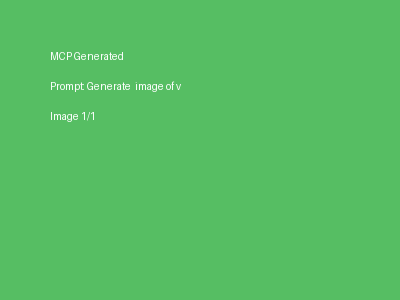

Stats: 1 total images, 0 bulk approvals

TESTING GEMINI-ENHANCED AGENT...

GEMINI AGENT: Analyzing 'create 3 abstract colour images'
❌ Gemini error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash-exp\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash-exp\nPlease retry in 32.769943722s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]},

✅ Approve? (yes/no):  yes


✅ Bulk request approved!
 Using MCP server to generate images...
 Generated 3 image(s)


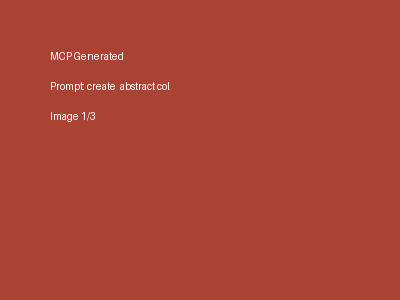

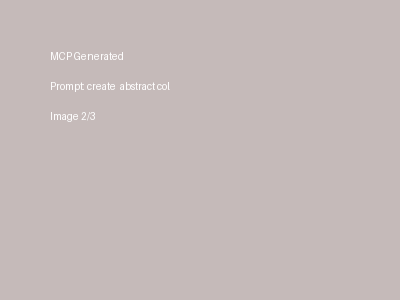

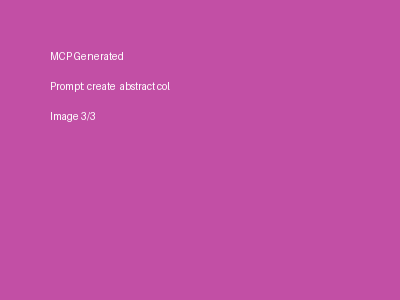

Stats: 3 total images, 1 bulk approvals
MCP AGENT SYSTEM WORKING PERFECTLY!


In [26]:
await main ()